Visualize exponential coordinates ($r = \lambda \theta$) for $SO(3)$,
but only show a slice of space by setting $\lambda_z = 0$

In [1]:
import einops
import numpy as np
from numpy.linalg import norm
from PIL import Image

In [2]:
# Generic SO(3).


def wrap_angle(th):
    """Wrap angle onto [-pi, pi]."""
    return np.mod(th + np.pi, 2 * np.pi) - np.pi


def wrap_ax_ang(ax, th):
    """
    Wraps angle onto [-pi, pi]. If ang is negative, flip both its sign and the
    axis's sign.
    """
    th = wrap_angle(th)
    neg = th < 0
    th[neg] *= -1
    ax[neg] *= -1
    return ax, th


def decompose_ax_ang_restricted(r, *, tol=1e-10):
    """
    Given R^3 represent so(3), decompose into angle [0, pi) and axis.
    In this restricted domain, we have a bijective map with SO(3).
    """
    th = norm(r, axis=-1)
    good = th > tol
    ax = np.zeros_like(r)
    ax[~good, :] = np.array([1, 0, 0])
    ax[good] = r[good] / th[good].reshape((-1, 1))
    ax, th = wrap_ax_ang(ax, th)
    assert np.all((th >= 0.0) & (th <= np.pi))
    return ax, th


# Visualization for restricted 2D subspace thinger.


def calc_ax_gamma(ax):
    """
    Given axis that is restricted to z=0, calculate angle (gamma) that can
    produce axis.
    """
    assert np.all(ax[:, 2] == 0)
    gamma = np.arctan2(ax[:, 1], ax[:, 0])
    return gamma


def _reshape_interpoland(c):
    if c.ndim != 2:
        c = c.reshape((1, -1))
    return c


def interp(s, a, b, *, si=0, sf=1):
    s = (s - si) / (sf - si)
    s = np.clip(s, 0, 1)
    s = s.reshape((-1, 1))
    a = _reshape_interpoland(a)
    b = _reshape_interpoland(b)
    return a + s * (b - a)


def color_ax_ang(ax, th):
    """
    Takes output of decompose_ax_ang_restricted() and adds purty colors.
    The same color should correspond to the same SO(3), and there should
    be no colors that are the same but do not represnt same SO(3).
    """
    nx, ny = th.shape
    ax = einops.rearrange(ax, "nx ny c -> (nx ny) c")
    th = einops.rearrange(th, "nx ny -> (nx ny)")
    # Axis - interp from red (0) to blue (pi) to red (0)
    ax_start = np.array([1, 0, 0])
    ax_end = np.array([0, 0, 1])
    # Compute blending based on axis using 2d angle.
    ax_gamma = calc_ax_gamma(ax)
    # Blend based on axis, then based on angle.
    ax_color = interp(ax_gamma, ax_start, ax_end, si=-np.pi, sf=np.pi)
    # Angle - from white to axis color. 
    th_start = np.array([0, 0, 0])
    # Angle magnitude of zero should be equivalent, regardless of axes.
    color = interp(th, th_start, ax_color, si=0, sf=np.pi)
    color = einops.rearrange(color, "(nx ny) c -> nx ny c", nx=nx, ny=ny)
    return color
    

def to_pil(x):
    assert x.dtype == float
    x = (x * 255).astype(np.uint8)
    return Image.fromarray(x)

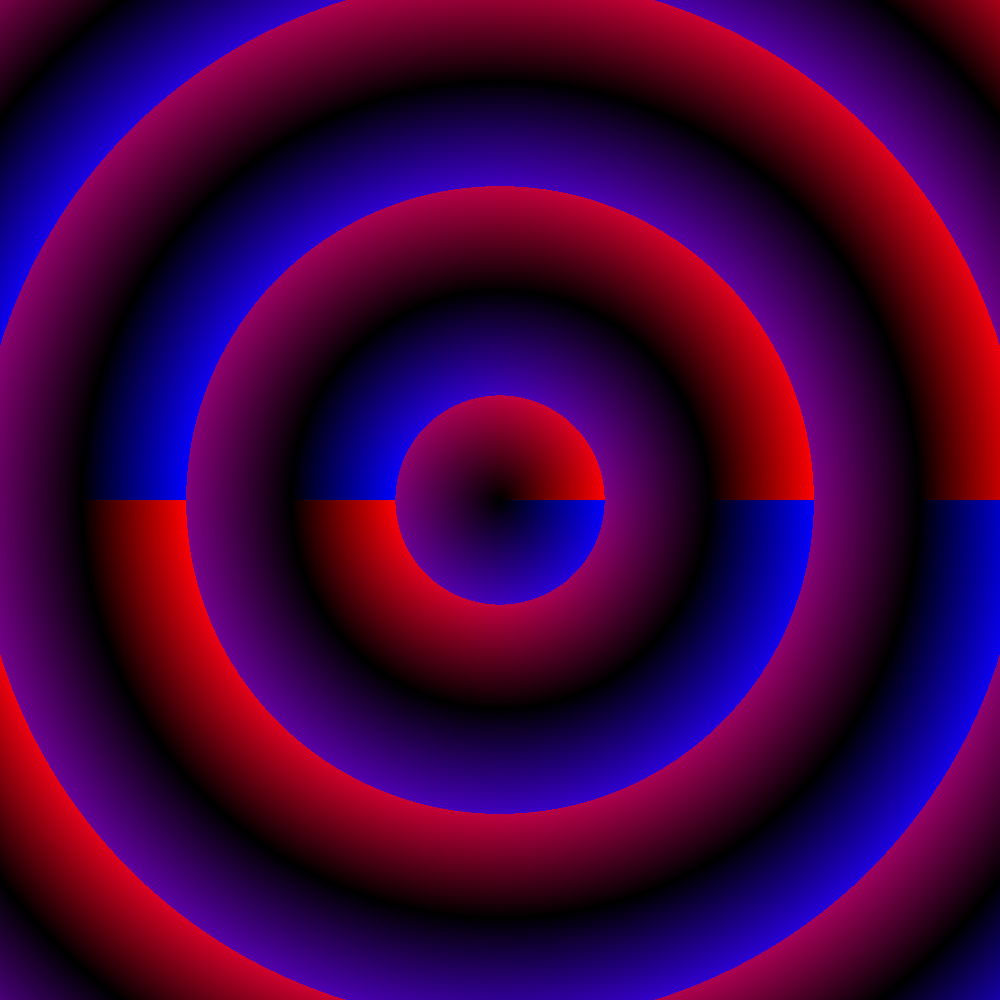

In [3]:
# Make grid of R^2
nx = 1000
ny = nx
bound = 15
xs = np.linspace(-bound, bound, nx)
ys = np.linspace(-bound, bound, ny)
X, Y = np.meshgrid(xs, ys)
Z = np.zeros_like(X)
rs = np.stack((X, Y, Z), axis=-1)

ax, ang = decompose_ax_ang_restricted(rs)
img = color_ax_ang(ax, ang)
img = img[:, ::-1, :]

to_pil(img)